In [566]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol
from scipy.stats import norm
from scipy.stats import qmc
sympy.init_printing()

In [567]:
basis = 'leguerre'

# parameters

mu = 0.02
r = 0.02
T = 1
I = 250
paths = 10
S0 = 40
S0_list = range(37, 43, 1)
m = 0
K = 40

GBM_sigma = 0.04
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

In [568]:
number_of_samples = I * paths

# Create a Sobol sequence generator
sobol = Sobol(d=2, scramble=True)  # 1-dimensional sequence

# Generate quasi-random numbers in the range [0, 1]
quasi_random_uniform = sobol.random_base2(m=int(np.log2(number_of_samples)))

# Transform the quasi-random numbers to a normal distribution
# Using the Percent Point Function (PPF), which is the inverse of the CDF
quasi_random_normal = norm.ppf(quasi_random_uniform)

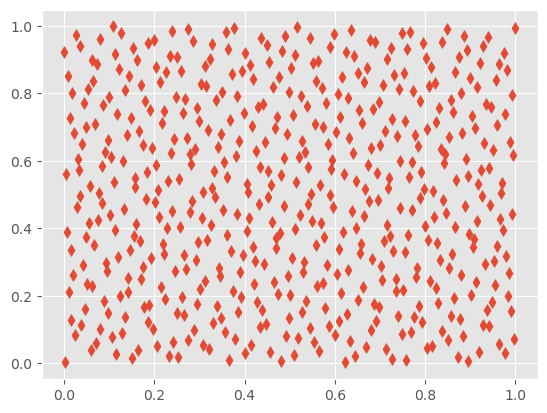

In [569]:
def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m=int(np.log2(number_of_samples)))
    return stats.norm.ppf(x_sobol)

x = sobol(m=9, d=2).T
plt.scatter(x[0],x[1], marker='d')

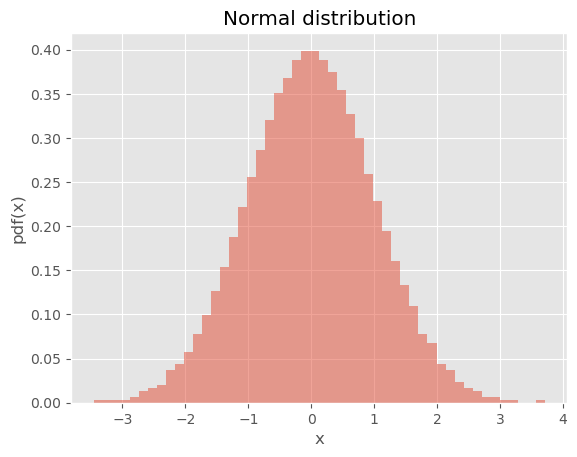

In [602]:
norm_dist=sobol_norm(m, d=1)

#plot the normal distribution

plt.hist(norm_dist, bins=50, density=True, histtype='stepfilled', alpha=0.5)
plt.title('Normal distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.show()

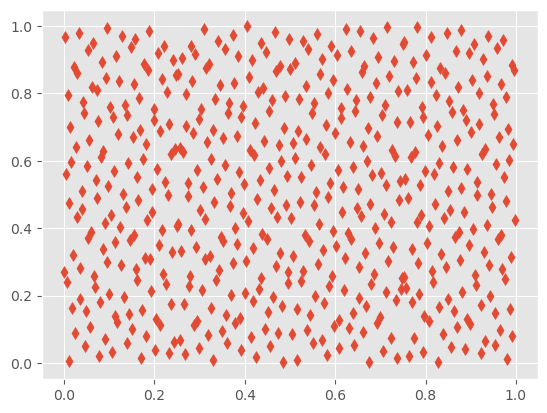

In [570]:
def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m=int(np.log2(number_of_samples)))
    np.random.shuffle(x_sobol)
    return stats.norm.ppf(x_sobol)

x = sobol(m=9, d=2).T
plt.scatter(x[0],x[1], marker='d')

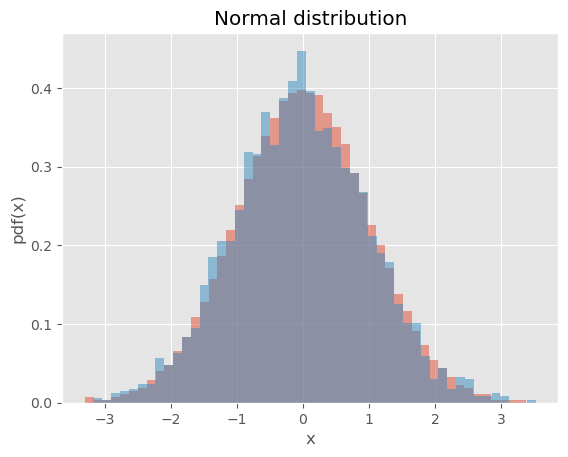

In [605]:
norm_dist = sobol_norm(m, d=1)

#plot the normal distribution besides a pseudo random normal distribution

plt.hist(norm_dist, bins=50, density=True, histtype='stepfilled', alpha=0.5)
plt.hist(np.random.normal(size=number_of_samples), bins=50, density=True, histtype='stepfilled', alpha=0.5)
plt.title('Normal distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.show()

In [571]:
def gbm_paths_sobol(S0, mu, sigma, T, I, paths, d):
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    quasi_random_numbers = sobol_norm(m=int(np.log2(I * paths)), d=d)
    matrix = np.zeros((paths, I))
    quasi_random_index = 0  # Index to track the current quasi-random number
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = quasi_random_numbers[quasi_random_index % len(quasi_random_numbers)]
            quasi_random_index += 1
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [572]:
gbm_paths_sobol = gbm_paths_sobol(S0, mu, GBM_sigma, T, I, paths, d=1)

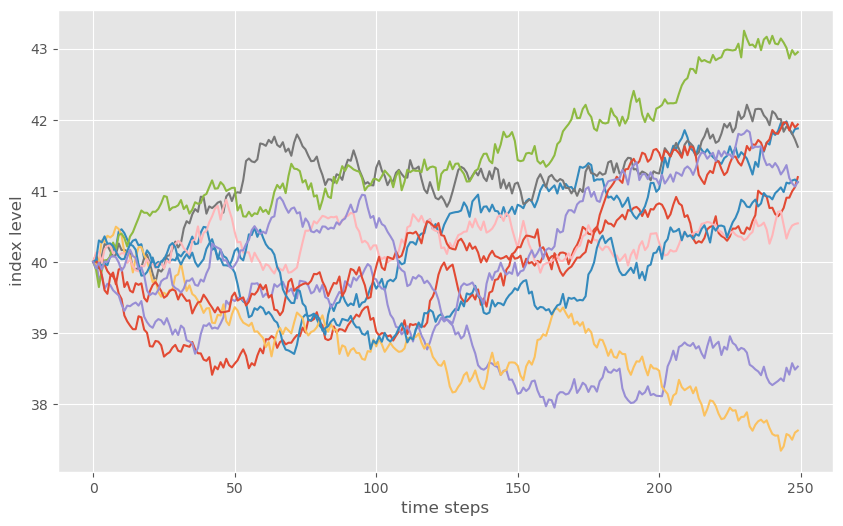

In [573]:
plt.figure(figsize=(10, 6))
plt.plot(gbm_paths_sobol.T[:,:10])
plt.xlabel('time steps')
plt.ylabel('index level')
plt.grid(True)
plt.show()

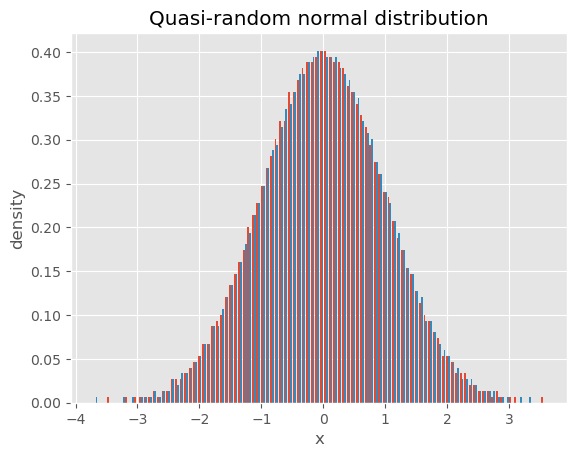

In [574]:
#plot the distribution
fig, ax = plt.subplots()
ax.hist(quasi_random_normal, bins=100, density=True)
ax.set_title('Quasi-random normal distribution')
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.show()


In [575]:
def generate_quasi_random_normal(number_of_samples):
    # Create a Sobol sequence generator
    sobol = Sobol(d=1, scramble=True)  # 1-dimensional sequence

    # Generate quasi-random numbers in the range [0, 1]
    quasi_random_uniform = sobol.random_base2(m=int(np.log2(number_of_samples)))

    # Transform the quasi-random numbers to a normal distribution
    return norm.ppf(quasi_random_uniform)

def gbm_paths_sobol(S0, mu, sigma, T, I, paths, quasi_random_numbers):
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    matrix = np.zeros((paths, I))
    quasi_random_index = 0  # Index to track the current quasi-random number
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = quasi_random_numbers[quasi_random_index % len(quasi_random_numbers)]
            quasi_random_index += 1
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [576]:
def gbm_paths(S0, mu, sigma, T, I, paths):
    np.random.seed(42)
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    matrix = np.zeros((paths, I))
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = np.random.standard_normal()
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [577]:
# Total number of quasi-random samples needed
number_of_samples = paths * I

# Generate the quasi-random numbers
quasi_random_numbers = generate_quasi_random_normal(number_of_samples)

In [578]:
# Corrected function call
#quasi_gbm_paths = gbm_paths_sobol(S0, GBM_mu, GBM_sigma, T, I, paths, quasi_random_numbers)

In [579]:
#display_matrix(quasi_gbm_paths)

In [580]:
#plt.figure(figsize=(10, 6))
#plt.plot(quasi_gbm_paths.T, lw=1.5)
#plt.xlabel('time')
#plt.ylabel('index level')
#plt.grid(True)
#plt.show()

In [581]:
def LSM(K, S, I, df, basis, deg):
    paths = len(S)
    np.random.seed(42)
    H = np.maximum(K - S, 0)  # intrinsic values for put option
    V = np.zeros_like(H)  # value matrix
    V[:, -1] = H[:, -1]  # set value at maturity equal to intrinsic value

    # Valuation by LS Method
    for t in range(I - 2, 0, -1):
        good_paths = H[:, t] > 0  # paths where the intrinsic value is positive

        if np.sum(good_paths) > 0:
            if basis == 'poly':
                rg = np.polyfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polyval(rg, S[good_paths, t])
            elif basis == 'legendre':
                rg = np.polynomial.legendre.legfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.legendre.legval(S[good_paths, t], rg)
            elif basis =='laguerre':
                rg = np.polynomial.laguerre.lagfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.laguerre.lagval(S[good_paths, t], rg)
            else:  # 'hermite'
                rg = np.polynomial.hermite.hermfit(S[good_paths, t], V[good_paths, t + 1] * df, deg)
                C = np.polynomial.hermite.hermval(S[good_paths, t], rg)

            exercise = np.zeros(len(good_paths), dtype=bool)
            exercise[good_paths] = H[good_paths, t] > C
        else:
            # If all intrinsic values are zero, mark all as non-exercise
            exercise = np.zeros(len(good_paths), dtype=bool)

        V[exercise, t] = H[exercise, t]
        V[exercise, t + 1 :] = 0
        discount_path = ~exercise
        V[discount_path, t] = V[discount_path, t + 1] * df

    V0 = np.mean(V[:, 1]) * df  # discounted expectation of V[t=1]
    V0_array = V[:, 1] * df
    SE = np.std(V[:, 1] * df) / np.sqrt(paths)
    variance = np.var(V[:, 1] * df)
    return V0, V0_array, SE, variance

In [582]:
quasi_gbm_paths = gbm_paths_sobol(S0, GBM_mu, GBM_sigma, T, I, paths, quasi_random_numbers)

gbm_paths = gbm_paths(S0, GBM_mu, GBM_sigma, T, I, paths)

In [583]:
V0_quasi, V0_array_quasi, SE_quasi, variance_quasi = LSM(K, quasi_gbm_paths, I, np.exp(-r * T), basis, 2)
V0, V0_array, SE, variance = LSM(K, gbm_paths, I, np.exp(-r * T), basis, 2)

print('Quasi-random numbers')
print('V0: ', V0_quasi.round(5))
print('SE: ', SE_quasi.round(5))
print('Variance: ', variance_quasi.round(5))
print('Random numbers')
print('V0: ', V0.round(5))
print('SE: ', SE.round(5))
print('Variance: ', variance.round(5))

Quasi-random numbers
V0:  0.12465
SE:  0.02664
Variance:  0.0071
Random numbers
V0:  0.26624
SE:  0.05858
Variance:  0.03431


/Users/philipgadereumert/opt/anaconda3/lib/python3.9/site-packages/numpy/polynomial/hermite.py:1403: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermvander, x, y, deg, rcond, full, w)


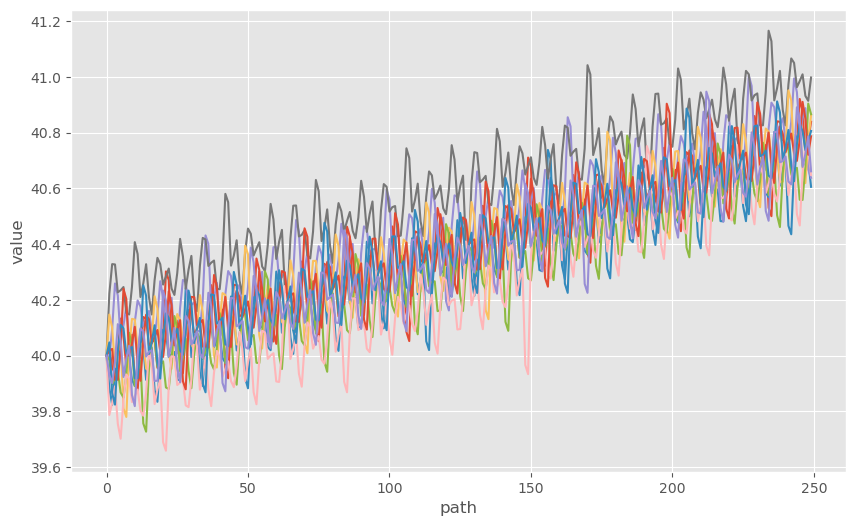

In [584]:
plt.figure(figsize=(10, 6))
plt.plot(quasi_gbm_paths.T, lw=1.5)
plt.xlabel('path')
plt.ylabel('value')
plt.grid(True)
plt.show()


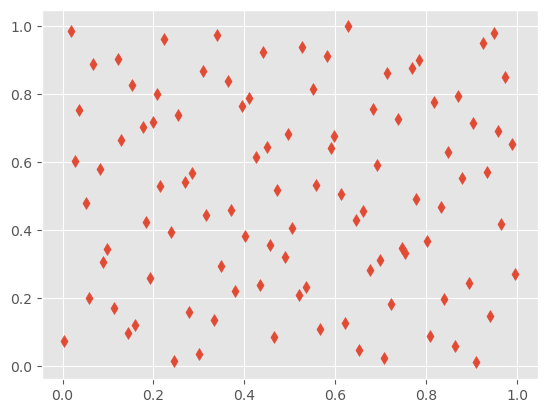

In [585]:
from scipy.stats import qmc

def halton(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    return sampler.random(n)

def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)
    return stats.norm.ppf(x_halton)

x = halton(n=100, d=2).T
plt.scatter(x[0],x[1], marker='d')

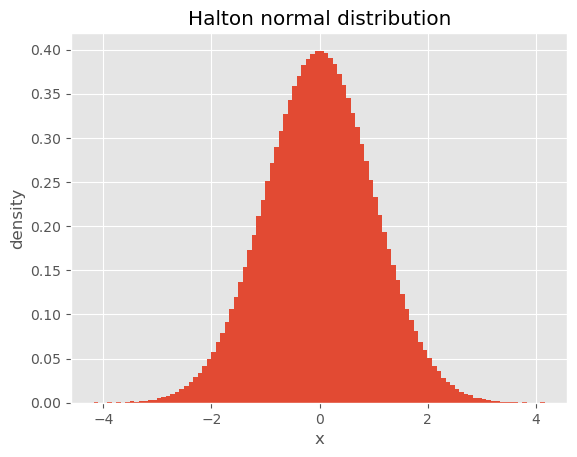

In [586]:
#plot the halton_norm distribution
fig, ax = plt.subplots()
ax.hist(halton_norm(20000), bins=100, density=True)
ax.set_title('Halton normal distribution')
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.show()

In [587]:
def gbm_paths(S0, mu, sigma, T, I, paths):
    np.random.seed(42)
    S0, paths, I, T = S0, paths, I, T
    dt = T / I
    matrix = np.zeros((paths, I))
    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = np.random.standard_normal()
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [588]:
def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)
    return stats.norm.ppf(x_halton)

def gbm_paths_halton(S0, mu, sigma, T, I, paths):
    dt = T / I
    matrix = np.zeros((paths, I))

    # Generate Halton sequence
    halton_sequence = halton_norm(paths * I).reshape(paths, I)

    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            # Use Halton sequence instead of standard normal
            Z = halton_sequence[k, i]
            S[i] = S[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

In [589]:
gbm_paths_halton = gbm_paths_halton(S0, GBM_mu, GBM_sigma, T, I, 10)

In [590]:
import numpy as np
from scipy.stats import qmc, norm

def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)
    return norm.ppf(x_halton)

def gbm_paths_halton(S0, mu, sigma, T, I, paths):
    dt = T / I
    matrix = np.zeros((paths, I))
    halton_sequence = halton_norm(paths * I, 1).flatten()
    halton_index = 0

    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = halton_sequence[halton_index]  # Use Halton sequence value
            halton_index += 1
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S

    return matrix

# Example call
gbm_paths_halton_result = gbm_paths_halton(S0, GBM_mu, GBM_sigma, T, I, 1)


In [591]:
#def gbm_paths_halton(S0, mu, sigma, T, I, paths):
#    dt = T / I
#    matrix = np.zeros((paths, I))
#
#    for k in range(paths):
#        S = np.zeros(I)
#        S[0] = S0
#        for i in range(1, I):
#            # Generate Halton sequence for each time step
#            Z = halton_norm(1)[0]  # Generate a single value from the Halton sequence
#            S[i] = S[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
#        matrix[k] = S
#    return matrix
#
#gbm_paths_halton_result = gbm_paths_halton(S0, GBM_mu, GBM_sigma, T, I, 1000)

In [592]:
def gbm_paths_halton(S0, mu, sigma, T, I, paths):
    dt = T / I
    matrix = np.zeros((paths, I))
    
    # Generate a Halton sequence matrix for all paths and time steps
    Z_matrix = halton_norm(paths * I).reshape(paths, I)

    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            # Use a pre-generated value from the Halton sequence
            Z = Z_matrix[k, i]
            S[i] = S[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

gbm_paths_halton_result = gbm_paths_halton(S0, GBM_mu, GBM_sigma, T, I, 1000)

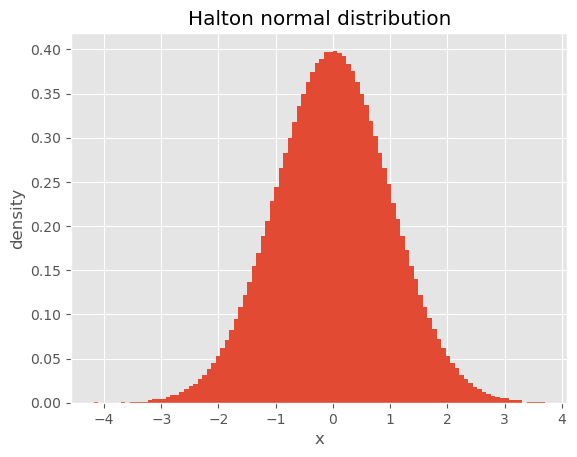

In [593]:
#plot the halton_norm distribution

fig, ax = plt.subplots()
ax.hist(halton_norm(10000), bins=100, density=True)
ax.set_title('Halton normal distribution')
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.show()

In [594]:
def halton_norm(n, d=1):
    sampler = qmc.Halton(d, scramble=True)
    x_halton = sampler.random(n)

    # Shuffle the Halton sequence
    np.random.shuffle(x_halton)

    # Apply the norm.ppf transformation to the shuffled sequence
    return norm.ppf(x_halton)


In [595]:
numbers = halton_norm(6)

numbers

array([[ 0.18541553],
       [-1.4498625 ],
       [-0.84681747],
       [ 0.9289729 ],
       [ 0.52023021],
       [-0.45779898]])

In [596]:
#numbers = halton_norm(paths*I).reshape(paths, I)
#
#display_matrix(numbers)

In [597]:
def gbm_paths_halton(S0, mu, sigma, T, I, paths):
    dt = T / I
    matrix = np.zeros((paths, I))

    # Generate a Halton sequence for all paths and time steps
    Z_sequence = halton_norm(paths * I).reshape(paths, I)

    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            # Use a unique value from the Halton sequence for each time step of each path
            Z = Z_sequence[k, i]
            S[i] = S[i - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

gbm_paths_halton_result = gbm_paths_halton(S0, GBM_mu, GBM_sigma, T, 10, 2)

In [598]:
dt = T / I
matrix = np.zeros((paths, I))
# Generate a Halton sequence for all paths and time steps
Z_sequence = halton_norm(paths * I).reshape(paths, I)
for k in range(paths):
    S = np.zeros(I)
    S[0] = S0
    for i in range(1, I):
        # Use a unique value from the Halton sequence for each time step of each path
        Z = Z_sequence[k, i]
        S[i] = S[i - 1] * np.exp((mu - 0.5 * GBM_sigma ** 2) * dt + GBM_sigma * np.sqrt(dt) * Z)
    matrix[k] = S



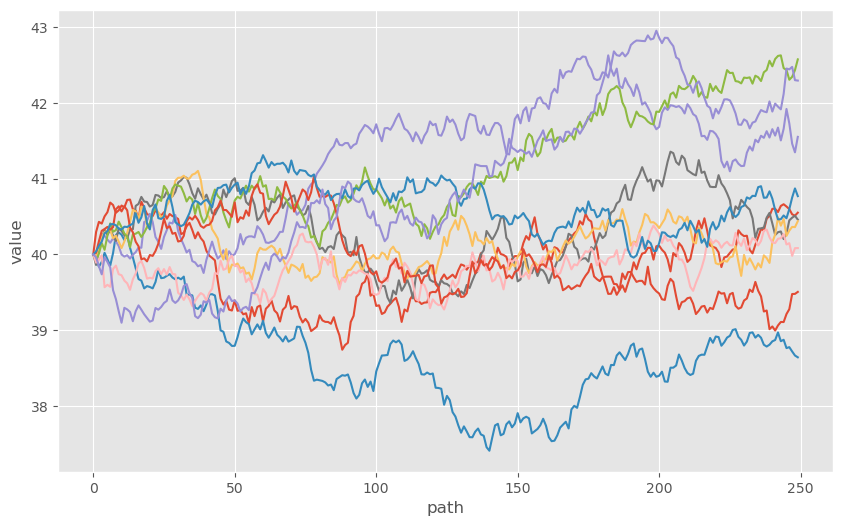

In [599]:
plt.figure(figsize=(10, 6))
plt.plot(matrix.T, lw=1.5)
plt.xlabel('path')
plt.ylabel('value')
plt.grid(True)
plt.show()

In [600]:
V0_quasi, V0_array_quasi, SE_quasi, variance_quasi = LSM(K, gbm_paths_halton_result, I, np.exp(-r * T), basis, 2)
V0, V0_array, SE, variance = LSM(K, gbm_paths, I, np.exp(-r * T), basis, 2)

print('Quasi-random numbers')
print('V0: ', V0_quasi.round(5))
print('SE: ', SE_quasi.round(5))
print('Variance: ', variance_quasi.round(5))
print('Random numbers')
print('V0: ', V0.round(5))
print('SE: ', SE.round(5))
print('Variance: ', variance.round(5))

IndexError: index 248 is out of bounds for axis 1 with size 10

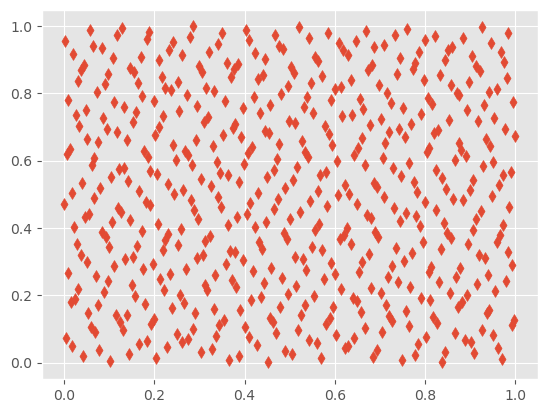

In [ ]:
def sobol(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    return sampler.random_base2(m)

def sobol_norm(m, d=1):
    sampler = qmc.Sobol(d, scramble=True)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

x = sobol(m=9, d=2).T
plt.scatter(x[0],x[1], marker='d')

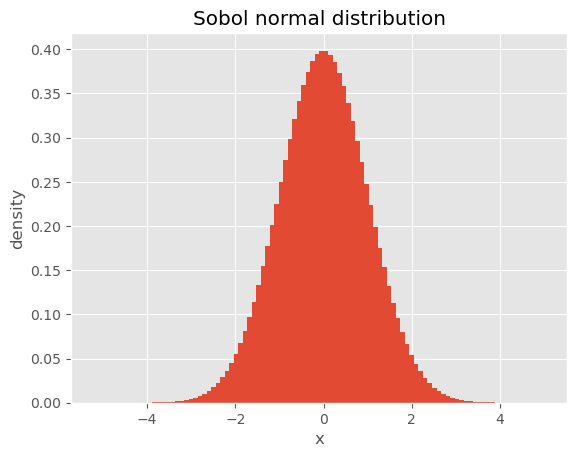

In [ ]:
#plot the sobol norm distribution
fig, ax = plt.subplots()
ax.hist(sobol_norm(20), bins=100, density=True)
ax.set_title('Sobol normal distribution')
ax.set_xlabel('x')
ax.set_ylabel('density')
plt.show()

In [ ]:
#length of x
x = sobol(m=8, d=1)
len(x)

In [ ]:
def gbm_paths_sobol(S0, mu, sigma, T, I, paths):
    dt = T / I
    matrix = np.zeros((paths, I))
    # Generate Sobol sequences for normal distribution
    sobol_norm_values = sobol_norm(paths * I, 1).flatten()
    sobol_index = 0

    for k in range(paths):
        S = np.zeros(I)
        S[0] = S0
        for i in range(1, I):
            Z = sobol_norm_values[sobol_index]  # Use Sobol sequence value
            sobol_index += 1
            S[i] = S[i-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
        matrix[k] = S
    return matrix

/var/folders/3l/9tdvgjyd6v12z560tdqxmwlm0000gn/T/ipykernel_13443/1830110275.py:41: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  Z = norm.ppf(sobol_sampler.random(n))


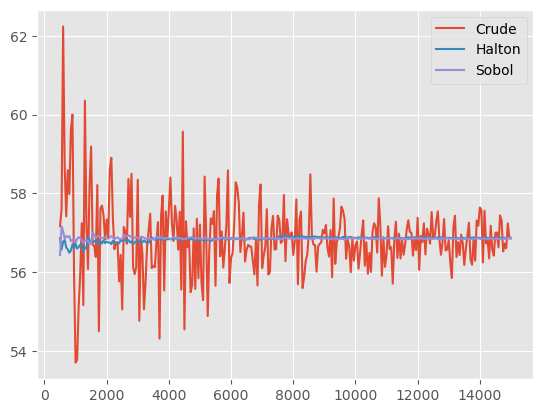

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import default_rng
from scipy.stats.qmc import Halton, Sobol

# Initializations
rng = default_rng()

# Inputs for GBM and call option
nvector = np.arange(500, 15001, 50)
k = 120
T = 10
r = 0.07
mu = r
sigma = 0.15
S0 = 115

# Space for mean estimates
Crudeestimates = np.empty(len(nvector))
Quasiestimates1 = np.empty(len(nvector))
Quasiestimates2 = np.empty(len(nvector))

# Starts simulation
for i, n in enumerate(nvector):
    # Crude Monte-Carlo simulation via pseudo random
    Z = norm.ppf(rng.uniform(0, 1, n))
    VFinalstockprice = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    vOptionValues = np.maximum(np.exp(-r * T) * (VFinalstockprice - k), 0)
    Crudeestimates[i] = np.mean(vOptionValues)

    # Quasi Monte-Carlo simulation using Halton sequence
    halton_sampler = Halton(d=1, scramble=True, seed=1000)
    Z = norm.ppf(halton_sampler.random(n))
    VFinalstockprice = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    vOptionValues = np.maximum(np.exp(-r * T) * (VFinalstockprice - k), 0)
    Quasiestimates1[i] = np.mean(vOptionValues)

    # Quasi Monte-Carlo simulation using Sobol sequence
    sobol_sampler = Sobol(d=1, scramble=True, seed=1000)
    Z = norm.ppf(sobol_sampler.random(n))
    VFinalstockprice = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    vOptionValues = np.maximum(np.exp(-r * T) * (VFinalstockprice - k), 0)
    Quasiestimates2[i] = np.mean(vOptionValues)

# Plotting the results
plt.plot(nvector, Crudeestimates, label='Crude')
plt.plot(nvector, Quasiestimates1, label='Halton')
plt.plot(nvector, Quasiestimates2, label='Sobol')
plt.legend()
plt.show()
